## 1) Import the necessary modules

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=add36b4f8278fff2d7a5b8cdcc9eaac43e63b0bc950832c3f9fdee9b488c6174
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
# import the necessary pyspark context and session
import pyspark.sql.context as sqlContext
from pyspark import SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Big_data project").config(
    "climate", "precip_temp").getOrCreate()
sc = SparkContext.getOrCreate()

In [ ]:
spark.version

'3.5.0'

In [ ]:
# Import functions and types
from pyspark.sql.functions import *
from pyspark.sql.types import *  # A pyspark module for data type and casting

## 2) Access and process the precipitation and temperature data

There are two ways with which we access the data. One, getting access directly from the website, or two, dowloading the data into a local PC directory. For precipitation data, I directly requested it from the website because it is stored per station. But for temperature data, I could not directly work from its website as is takes hours to access that data. I wrote the codes for each of them checked that the second method (downloading) is faster than direct access, particularly when we are dealing with many staions. Therefore, accessing big data through request takes long time than working with an already downloaded data. The location I am interested in (Ethiopia) has 1200+ stations. So, As far as the downloaded file size is not greater that the available computer space on a local drive, I downloaded using the following function. For this project, I used this downloaded data. If the readers of this code are interested to download, they can run the code below and wait an hour or two. Anyways I have provided code snippets for both cases as follows.

### 2.1) Access and prepare the monthly PRECIPITATION data from the website

In [ ]:
# Access the main data source and convert it to a single string
import requests

# Location for monthly data of the entire globe
url_prcp = 'https://www.ncei.noaa.gov/data/ghcnm/v4beta/access/'

# this converts the entire content of the web into a string
prcp_data = requests.get(url_prcp).text

Once the url is converted to text, then we can use any sort of text fuctions, methods, and attributes such as contactenations. That is very important when quiering the url in order to take data of a specific location of interest, let's say Ethiopia. To do so, first we have to study the text by printing it as follows.

In [ ]:
# Have a look at the first 1000 character stings,
# observe where the stations data starts (e.g. <tr><td><a href=)

# Precipitation
n = 0
for p in prcp_data:
    n += 1
    if n < 1000:  # I put this limit to prevent crashing of the note book.
        print(p, end = '')
    else:
        pass

# Temperature
# Unimportant to print

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<html>
 <head>
  <title>Index of /data/ghcnm/v4beta/access</title>
 </head>
 <body>
<h1>Index of /data/ghcnm/v4beta/access</h1>
  <table>
   <tr><th><a href="?C=N;O=D">Name</a></th><th><a href="?C=M;O=A">Last modified</a></th><th><a href="?C=S;O=A">Size</a></th><th><a href="?C=D;O=A">Description</a></th></tr>
   <tr><th colspan="4"><hr></th></tr>
<tr><td><a href="/data/ghcnm/v4beta/">Parent Directory</a></td><td>&nbsp;</td><td align="right">  - </td><td>&nbsp;</td></tr>
<tr><td><a href="ACW00011604.csv">ACW00011604.csv</a></td><td align="right">2024-02-04 16:23  </td><td align="right">770 </td><td>&nbsp;</td></tr>
<tr><td><a href="ACW00011647.csv">ACW00011647.csv</a></td><td align="right">2024-02-04 16:22  </td><td align="right"> 34K</td><td>&nbsp;</td></tr>
<tr><td><a href="ACXLP312520.csv">ACXLP312520.csv</a></td><td align="right">2024-02-04 16:26  </td><td align="right"> 14K</td><td>&nbsp;</td></tr>
<tr><td><a href="ACXLP31252

Now, when we study the above print, we can see there is a repetition of a pattern (look at the final four lines). After studying the metadata in the website, we noticed that the first 2 characters after href=" represent a country. For example 'ET' for Ethiopia, 'US' for United States and so ... on. That means we can use those two characters to extract data of our interest country. To do so, manuvering over the entire text is not a smart move. Instead, we can covert the text into a python list were we can play a lot using list functions and methods. So, the following snippet converts every line of the above text into a list element and make one big list.

In [ ]:
#  Count the total number of characters in the website,
#just to visualize the volume of the text
print("The number of characters for precipitation is {}.".format(len(prcp_data)))

The number of characters for precipitation is 18157162.


#### 2.1.1) Create list of text links for precipitation

As we can see from the output of the following cell, there are 18.544 million characters in this text, which is a big number, that is why we do not have to print all.

In [ ]:
# Convert the string into a list for convinience
stations_list_prcp = prcp_data.split("\n")
print(len(stations_list_prcp))  # Note that there were 18+ million characters;
#now changed into a list of a few words

123528


In [ ]:
# print and see the first few elements of the list, just to visualize it

# Precipitation
n = 0
for p in stations_list_prcp:
    n += 1
    if n < 20:  # making a big pring may crush the notebook in case of big list
        print(p)


<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<html>
 <head>
  <title>Index of /data/ghcnm/v4beta/access</title>
 </head>
 <body>
<h1>Index of /data/ghcnm/v4beta/access</h1>
  <table>
   <tr><th><a href="?C=N;O=D">Name</a></th><th><a href="?C=M;O=A">Last modified</a></th><th><a href="?C=S;O=A">Size</a></th><th><a href="?C=D;O=A">Description</a></th></tr>
   <tr><th colspan="4"><hr></th></tr>
<tr><td><a href="/data/ghcnm/v4beta/">Parent Directory</a></td><td>&nbsp;</td><td align="right">  - </td><td>&nbsp;</td></tr>
<tr><td><a href="ACW00011604.csv">ACW00011604.csv</a></td><td align="right">2024-02-04 16:23  </td><td align="right">770 </td><td>&nbsp;</td></tr>
<tr><td><a href="ACW00011647.csv">ACW00011647.csv</a></td><td align="right">2024-02-04 16:22  </td><td align="right"> 34K</td><td>&nbsp;</td></tr>
<tr><td><a href="ACXLP312520.csv">ACXLP312520.csv</a></td><td align="right">2024-02-04 16:26  </td><td align="right"> 14K</td><td>&nbsp;</td></tr>
<tr><td><a href="ACXLP312522

Now we can extract data only, for example, for Ethiopia. To do so, we have to create an other list for Ethiopia 'ET', which is located at the 12th, 13th, and 14th indices of each member of the above list. That is Ethiopia already. Moreover, readers may study the short comments I wrote infront of each line of code. Note also that the first 11 lines of list elements in the above print are not useful for us. They came from the html of the website.

#### 2.1.2)  Extract the area of interest for this project (Ethiopia) by slicing the list

In [ ]:
# Precipitation
et_prcp = []     # list for a country (e.g. 'Ethiopia')
counter = 0
# Valid list of daily records are found only after the 12th string in the list
for station in stations_list_prcp[11:]:
  # The 18th and 19th characters (e.g. 'ET' for Ethiopia) represent country
    if station[17:19] == "ET":
      # only 15 characters represent  the station (e.g. 'US1COAD0003.dly')
        et_prcp.append(station[17:32])
        counter += 1
    else:
        pass
print(et_prcp[:3])  # just see the first three memberst of the list
print("There are a total of {} stations in Ethiopia.".format(counter))

['ET000063330.csv', 'ET000063331.csv', 'ET000063332.csv']
There are a total of 167 stations in Ethiopia.


In [ ]:
# Precipitation
url_list_prcp = []
for station in et_prcp:
    link = url_prcp + station
    url_list_prcp.append(link)
print(url_list_prcp[2])

https://www.ncei.noaa.gov/data/ghcnm/v4beta/access/ET000063332.csv


 Create a list of complete urls for the selected country. Note that from now on, this is a list we will iterate over.

In [ ]:
# Precipitation
# Create a list of requested data and store it.
data_list_prcp = []
for station in url_list_prcp:
    data = requests.get(station).text
    data_list_prcp.append(data)

### 2.2) Access monthly TEMPERATURE data, already downloaded and stored in local PC

I am using an laready downloaded data from my PC. The reason for using locally downloaded data has been well explanined in the preveious text.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Temperature data
temp_text_file = "/content/drive/MyDrive/IGSSA_AAU/Year_1/Big_Data/2024_02_01_ghcnm.tavg.v4.0.1.20240130.txt"
import os
temp_data = open(temp_text_file, 'r')     # open
temp_data2 = temp_data.readlines()        # read as a list
print("The  number of characters for temperature is {}.".format(len(temp_data2)))
print(temp_data2[80])

The  number of characters for temperature is 1453801.
AE0000411961960TAVG 1952  I 1983  I 2130  I 2530  I 2820  I 3086  I 3330  I 3390  I 3127  I 2756  I 2403  I 1992  I



This is a huge list containing 1.45 million elements, each with at least 14 columns of temperature data. Therefore, to save processing time, we have to extract our interest area before further analysis such as rdd and dataframes. So the following snippet extracts temperature data for Ethiopia.

In [ ]:
e_temp = []
for i in temp_data2:
    country_code = i[:2]
    if country_code == 'ET':
        e_temp.append(i)
    else:
        pass
print(e_temp[2])

ET0000633301965TAVG 1464  Q 1577  Q 1642  Q 1839  Q 2000  Q 1964  Q 1754  Q 1600  Q 1669  Q 1610  Q 1551  Q 1506  Q



## 3) Create RDDs

Now we have gotten a complete list of urls for out interest area (Ethiopia in this case). Therefore, we can create a list of RDD files from the data of each of the stations. To do that we carefully studied the metadata from this website https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-monthly. From the metadata we noticed that the monthly PRECIPITAYTION data was recorded and put in 3 separate columns. And the temerature data was stored over 12 columins, each representing a month in the year. Therefore, we had to locate the indices for each and put them in the lambada function as follows.

### 3.1) Create RDDs for Precipitation

Parallelize the precipiation data that was accessed from the website and prepared aboove.

In [ ]:
# Parallelize the precipitation data.
rdd_list_prcp1 = []
for data in data_list_prcp:
    rdd = sc.parallelize(data.splitlines())
    rdd_list_prcp1.append(rdd)

Map the Precipitation data using the lambda function.

In [ ]:
# Map it
rdd_list_prcp2 =[]
for rdd in rdd_list_prcp1:
    rdd_2 = rdd.map(lambda x: (x[:11], x[12:52], float(x[53:62]), float(x[63:73]), float(x[74:82]), int(x[83:89]), float(x[90:96]), x[103:109]))
    rdd_list_prcp2.append(rdd_2)

For full understanding of the below lambda fuction, the metadata can be accessed from this link https://www.ncei.noaa.gov/data/ghcnm/v4beta/doc/ghcn-m_v4_prcp_readme.txt

In [ ]:
# See Precipitation RDD
rdd_list_prcp2[0].take(2)

[('ET000063330',
  '                                "MEKELE"',
  13.3,
  39.29,
  2212.0,
  193701,
  30.0,
  '102448'),
 ('ET000063330',
  '                                "MEKELE"',
  13.3,
  39.29,
  2212.0,
  193702,
  10.0,
  '102448')]

### 3.2) Create RDDs for Temperature

Parallelize and map the temperature data that was already downloaded and prepared previously.

In [ ]:
rdd_temp = sc.parallelize(e_temp)

In [ ]:
rdd_temp.take(3)

['ET0000633301963TAVG-9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999    1675  Q 1649  Q 1461  Q\n',
 'ET0000633301964TAVG 1608  Q 1707  Q 1809  Q 1829  Q 1974  Q 1965  Q 1585  Q 1595  Q-9999    1537  Q 1419  Q 1398  Q\n',
 'ET0000633301965TAVG 1464  Q 1577  Q 1642  Q 1839  Q 2000  Q 1964  Q 1754  Q 1600  Q 1669  Q 1610  Q 1551  Q 1506  Q\n']

Map the temperature rdd.

In [ ]:
rdd_temp2 = rdd_temp.map(
    lambda x: (x[:11], x[11:15], x[15:19], float(x[19:24]),
               float(x[27:32]), float(x[35:40]), float(x[43:48]),
               float(x[51:56]), float(x[59:64]), float(x[67:72]),
               float(x[75:80]), float(x[83:88]), float(x[91:96]),
               float(x[99:104]), float(x[107:112])))

Map the Temperature data using the lambda function. Metadata for this lambda classification is given here https://www.ncei.noaa.gov/data/global-historical-climatology-network-monthly/v4/doc/readme.txt

In [ ]:
rdd_temp2.take(2)

[('ET000063330',
  '1963',
  'TAVG',
  -9999.0,
  -9999.0,
  -9999.0,
  -9999.0,
  -9999.0,
  -9999.0,
  -9999.0,
  -9999.0,
  -9999.0,
  1675.0,
  1649.0,
  1461.0),
 ('ET000063330',
  '1964',
  'TAVG',
  1608.0,
  1707.0,
  1809.0,
  1829.0,
  1974.0,
  1965.0,
  1585.0,
  1595.0,
  -9999.0,
  1537.0,
  1419.0,
  1398.0)]

Count the number of rdd records for data from just one of the stations in the selected country, this activity is totally optional and commented out because counting is an expensive task in Pyspark.

In [ ]:
# rdd_list_2[10].count()

## 4) Create dataframes

Before we continue dataframe creation, it is worth to note that there are two ways to deal with our rdd. The first is to combine all the RDDs by using making From now on, we can create dataframe for all stations. To do that we must create schema for the dataframes. The schema decides the type of data (e.g integer, float, etc...) for each of the columns. I tried to combine all rdds before dataframe creation and it was not timeefficient. So I have decided to use for loop.

### 4.1) Create dataframe for precipitation

Design the schema for the upcoming dataframe, Note that the data type comes from the metadata.

In [ ]:
# Precipitation schema
schema_prcp = StructType([
    StructField("station_id", StringType(), True),
    StructField("station_name", StringType(), True),
    StructField("lat", FloatType(), True),
    StructField("lon", FloatType(), True),
    StructField("elev_m", FloatType(), True),
    StructField("yyyymm", StringType(), True),
    StructField("prcp_10mm", FloatType(), True),
    StructField("index", StringType(), True)])

In [ ]:
# Precipitation dataframe
dfs_prcp = []
for rdd in rdd_list_prcp2:
    df = spark.createDataFrame(rdd, schema_prcp)
    dfs_prcp.append(df)

In [ ]:
dfs_prcp[45].show(3)    # Just to see just one row from one of the dataframe

+-----------+--------------------+----+----+------+------+---------+------+
| station_id|        station_name| lat| lon|elev_m|yyyymm|prcp_10mm| index|
+-----------+--------------------+----+----+------+------+---------+------+
|ETXLP334695|                 ...|14.3|36.6| 760.0|196809|    590.0|108540|
|ETXLP334695|                 ...|14.3|36.6| 760.0|196810|    110.0|108540|
|ETXLP334695|                 ...|14.3|36.6| 760.0|196811|      0.0|108540|
+-----------+--------------------+----+----+------+------+---------+------+
only showing top 3 rows



### 4.2) Create dataframe for temperature, and transporse it

In [ ]:
# Temperature schema
schema_temp = StructType([
    StructField("station_id", StringType(), True),
    StructField("year", StringType(), True),
    StructField("avg_temp", StringType(), True),
    StructField("01", FloatType(), True), StructField("02", FloatType(), True),
    StructField("03", FloatType(), True), StructField("04", FloatType(), True),
    StructField("05", FloatType(), True), StructField("06", FloatType(), True),
    StructField("07", FloatType(), True), StructField("08", FloatType(), True),
    StructField("09", FloatType(), True), StructField("10", FloatType(), True),
    StructField("11", FloatType(), True), StructField("12", FloatType(), True)
])

In [ ]:
# Temperature dataframe
df_temp = spark.createDataFrame(rdd_temp2, schema_temp)

In [ ]:
df_temp.show(8)

+-----------+----+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+-------+
| station_id|year|avg_temp|     01|     02|     03|     04|     05|     06|     07|     08|     09|    10|    11|     12|
+-----------+----+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+-------+
|ET000063330|1963|    TAVG|-9999.0|-9999.0|-9999.0|-9999.0|-9999.0|-9999.0|-9999.0|-9999.0|-9999.0|1675.0|1649.0| 1461.0|
|ET000063330|1964|    TAVG| 1608.0| 1707.0| 1809.0| 1829.0| 1974.0| 1965.0| 1585.0| 1595.0|-9999.0|1537.0|1419.0| 1398.0|
|ET000063330|1965|    TAVG| 1464.0| 1577.0| 1642.0| 1839.0| 2000.0| 1964.0| 1754.0| 1600.0| 1669.0|1610.0|1551.0| 1506.0|
|ET000063330|1966|    TAVG| 1538.0| 1649.0| 1777.0| 1868.0| 1967.0| 1989.0| 1738.0| 1645.0| 1687.0|1660.0|1505.0| 1401.0|
|ET000063330|1967|    TAVG| 1401.0| 1612.0| 1749.0| 1823.0| 1883.0| 1903.0| 1611.0| 1528.0| 1669.0|1577.0|1520.0| 1420.0|
|ET000063330|1968|    TA

In [ ]:
df_temp.count()

1123

Transpose the data, that means insert the monthly data from the columons to rows for each year.

In [ ]:
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
df_temp2 = df_temp.unpivot(["station_id", "year"], months, "var", "val")

In [ ]:
df_temp2.show(8)

+-----------+----+---+-------+
| station_id|year|var|    val|
+-----------+----+---+-------+
|ET000063330|1963| 01|-9999.0|
|ET000063330|1963| 02|-9999.0|
|ET000063330|1963| 03|-9999.0|
|ET000063330|1963| 04|-9999.0|
|ET000063330|1963| 05|-9999.0|
|ET000063330|1963| 06|-9999.0|
|ET000063330|1963| 07|-9999.0|
|ET000063330|1963| 08|-9999.0|
+-----------+----+---+-------+
only showing top 8 rows



In [ ]:
df_temp2.printSchema()
df_temp2.count()

root
 |-- station_id: string (nullable = true)
 |-- year: string (nullable = true)
 |-- var: string (nullable = false)
 |-- val: float (nullable = true)



13476

### 4.3) Prepare date-time information

#### 4.3.1) Create date column for precipitation data

In the precipitation data, a six-digit number is given comibined in one column for yearMONTH as (yyyyMM). Therefore, we can direclty use this information to create date column as follows.

In [ ]:
df_list2 = []
for df in dfs_prcp:
    df2 = df.withColumn("date", last_day(to_date(col("yyyymm").
                                                 cast("string"), "yyyyMM")))
    df_list2.append(df2)

In [ ]:
df_list2[4].show(8)

+-----------+--------------------+-----+-----+------+------+---------+------+----------+
| station_id|        station_name|  lat|  lon|elev_m|yyyymm|prcp_10mm| index|      date|
+-----------+--------------------+-----+-----+------+------+---------+------+----------+
|ET000063334|                 ...|10.27|37.82|2515.0|195301|      0.0|100356|1953-01-31|
|ET000063334|                 ...|10.27|37.82|2515.0|195302|    670.0|100356|1953-02-28|
|ET000063334|                 ...|10.27|37.82|2515.0|195303|     80.0|100356|1953-03-31|
|ET000063334|                 ...|10.27|37.82|2515.0|195304|    800.0|100356|1953-04-30|
|ET000063334|                 ...|10.27|37.82|2515.0|195305|    760.0|100356|1953-05-31|
|ET000063334|                 ...|10.27|37.82|2515.0|195306|   1460.0|100356|1953-06-30|
|ET000063334|                 ...|10.27|37.82|2515.0|195307|   2920.0|100356|1953-07-31|
|ET000063334|                 ...|10.27|37.82|2515.0|195308|   3200.0|100356|1953-08-31|
+-----------+--------

#### 4.3.2) Create date column for temperature data

In temperature data, the year and month are stored in two separate columns, therefore we had to first concatenate the two before creating date column as follows.

Concatenate year and month

In [ ]:
df_temp3 =  df_temp2.select(concat(df_temp2.year, df_temp2.var).
                            alias("yyyymm"), "station_id", "val")

Create date column

In [ ]:
df_temp4 = df_temp3.withColumn(
    "date", last_day(to_date(col("yyyymm").cast("string"), "yyyyMM")))

Give correct name to the average temperature data

In [ ]:
df_temp5 = df_temp4.withColumn('TAVG', df_temp3['val'])

Drop unecessary columns

In [ ]:
df_temp6 = df_temp5.drop('yyyymm', 'val')

In [ ]:
df_temp6.show(8)

+-----------+----------+-------+
| station_id|      date|   TAVG|
+-----------+----------+-------+
|ET000063330|1963-01-31|-9999.0|
|ET000063330|1963-02-28|-9999.0|
|ET000063330|1963-03-31|-9999.0|
|ET000063330|1963-04-30|-9999.0|
|ET000063330|1963-05-31|-9999.0|
|ET000063330|1963-06-30|-9999.0|
|ET000063330|1963-07-31|-9999.0|
|ET000063330|1963-08-31|-9999.0|
+-----------+----------+-------+
only showing top 8 rows



## 5) Combine precipitation and temperature data into one dataframe

Before further, process such as data cleaning and modeling, we need to put together both variables (precipitation and average temperature). To do so, we used join function with two conditions fullfilled: match station IDs AND match date. The 'date' in this sense is a year-month-last day combination.

In [ ]:
dfs = []
for df in df_list2:
    new_df = df.join(df_temp6, ['station_id', 'date']) \
    .select(df.station_id, df.station_name, df.date, df.lon,
           df.lat, df.elev_m, df.prcp_10mm, df_temp6.TAVG)
    dfs.append(new_df)

In [ ]:
dfs[6].show(8)

+-----------+--------------------+----------+------+----+------+---------+-------+
| station_id|        station_name|      date|   lon| lat|elev_m|prcp_10mm|   TAVG|
+-----------+--------------------+----------+------+----+------+---------+-------+
|ET000063403|                 ...|1953-09-30|35.533|8.15|2002.0|   3342.0| 1666.0|
|ET000063403|                 ...|1952-03-31| 35.53|8.15|2002.0|   1080.0|-9999.0|
|ET000063403|                 ...|1989-10-31| 35.53|8.15|2002.0|   3938.0| 1765.0|
|ET000063403|                 ...|1953-03-31|35.533|8.15|2002.0|    815.0| 1984.0|
|ET000063403|                 ...|1954-06-30|35.533|8.15|2002.0|   2349.0| 1684.0|
|ET000063403|                 ...|1965-03-31|35.533|8.15|2002.0|    964.0| 1942.0|
|ET000063403|                 ...|1970-08-31|35.533|8.15|2002.0|   3141.0| 1601.0|
|ET000063403|                 ...|1975-07-31|35.533|8.15|2002.0|   2945.0| 1584.0|
+-----------+--------------------+----------+------+----+------+---------+-------+
only

Remove white spaces and quotation marks from the 'station_name' column

In [ ]:
dfs_1 = []
for df in dfs:
   df_1 = df.select("station_id", "date", "lon", "lat",
                    "elev_m", "prcp_10mm", "TAVG",
                    ltrim("station_name").alias('station_1'))#removes white spaces
   df_11 = df_1.withColumn('station', regexp_replace('station_1', '"', ''))
   # removes the quotations
   dfs_1.append(df_11)

In [ ]:
dfs_1[6].show(8)

+-----------+----------+------+----+------+---------+-------+---------+-------+
| station_id|      date|   lon| lat|elev_m|prcp_10mm|   TAVG|station_1|station|
+-----------+----------+------+----+------+---------+-------+---------+-------+
|ET000063403|1953-09-30|35.533|8.15|2002.0|   3342.0| 1666.0|   "GORE"|   GORE|
|ET000063403|1952-03-31| 35.53|8.15|2002.0|   1080.0|-9999.0|   "GORE"|   GORE|
|ET000063403|1989-10-31| 35.53|8.15|2002.0|   3938.0| 1765.0|   "GORE"|   GORE|
|ET000063403|1953-03-31|35.533|8.15|2002.0|    815.0| 1984.0|   "GORE"|   GORE|
|ET000063403|1954-06-30|35.533|8.15|2002.0|   2349.0| 1684.0|   "GORE"|   GORE|
|ET000063403|1965-03-31|35.533|8.15|2002.0|    964.0| 1942.0|   "GORE"|   GORE|
|ET000063403|1970-08-31|35.533|8.15|2002.0|   3141.0| 1601.0|   "GORE"|   GORE|
|ET000063403|1975-07-31|35.533|8.15|2002.0|   2945.0| 1584.0|   "GORE"|   GORE|
+-----------+----------+------+----+------+---------+-------+---------+-------+
only showing top 8 rows



There is a varying longitude and latitude values for one station. So we need to make one and only one lat, lon. Let's do it as follows

First draw only the station ids and the coordinates

In [ ]:
df_2 = []
for df in dfs_1:
    df2 = df.select('station_id','lon','lat')
    df_2.append(df2)

Then make distinct values for each statation

In [ ]:
df_3 = []
duplicate_counts = []
for df in df_2:
  df3 = df.distinct()
  c = df3.count()
  if c > 0:
    duplicate_counts.append(c)
    df_3.append(df3)
print(duplicate_counts)

[2, 7, 3, 3, 3, 4, 3, 2, 3, 3, 4, 3, 2, 2]


The number of counts for each station should have been exactly 1, which is not the case as can be observed from the above result. So let's do the aggregation as follows.

In [ ]:
df_4 = []
for df in df_3:
  df4 = df.groupBy("station_id").agg(avg("lon").alias("longitude"),avg("lat").alias("latitude"))
  df_4.append(df4)

Now let's see the outcome

In [ ]:
cnt = []
for df in df_4:
  c = df.count()
  cnt.append(c)
print(cnt)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
unique_stations = df_4[0]
for df in df_4[1:]:
  unique_stations = unique_stations.union(df)

In [ ]:
unique_stations.show()

+-----------+------------------+------------------+
| station_id|         longitude|          latitude|
+-----------+------------------+------------------+
|ET000063330| 39.49150085449219|              13.5|
|ET000063331| 37.40767124720982|12.524285861424037|
|ET000063332| 37.36233266194662|11.510000228881836|
|ET000063333| 39.72876739501953| 11.10456657409668|
|ET000063334| 37.71899922688802|10.311000188191732|
|ET000063402| 36.82907581329346| 7.668424963951111|
|ET000063403| 35.53209940592448| 8.149999618530273|
|ET000063451| 38.98500061035156| 8.581500053405762|
|ET000063453|40.050000508626304| 8.913333257039389|
|ET000063471| 41.72999954223633| 9.516667048136393|
|ET000063473|42.659250259399414| 9.295750141143799|
|ET000063474|              40.0| 7.087666670481364|
|ET000063478| 43.30649948120117| 5.980000019073486|
|ET000063533| 39.68499946594238| 5.315000057220459|
+-----------+------------------+------------------+



In [ ]:
unique_stations.count()

14

Now join the new latitude and longitude values to the main dataframe

In [ ]:
dfs2 = []
for df in dfs_1:
  df2 = df.join(unique_stations, ['station_id']).select(df.station_id, df.station,
      df.date, df.elev_m, df.prcp_10mm, df.TAVG, unique_stations.longitude,
      unique_stations.latitude)
  dfs2.append(df2)

In [ ]:
dfs2[4].show(4)

+-----------+-----------+----------+------+---------+-------+-----------------+------------------+
| station_id|    station|      date|elev_m|prcp_10mm|   TAVG|        longitude|          latitude|
+-----------+-----------+----------+------+---------+-------+-----------------+------------------+
|ET000063334|DEBREMARCOS|1957-01-31|2515.0|      0.0| 1602.0|37.71899922688802|10.311000188191732|
|ET000063334|DEBREMARCOS|1967-09-30|2515.0|   2427.0| 1442.0|37.71899922688802|10.311000188191732|
|ET000063334|DEBREMARCOS|1969-08-31|2515.0|   3140.0|-9999.0|37.71899922688802|10.311000188191732|
|ET000063334|DEBREMARCOS|1971-04-30|2515.0|    185.0|-9999.0|37.71899922688802|10.311000188191732|
+-----------+-----------+----------+------+---------+-------+-----------------+------------------+
only showing top 4 rows



See the total number of stations we are working with

In [ ]:
print("The number of stations for this project in Ethiopia is", len(dfs2))

The number of stations for this project in Ethiopia is 167


## 6) Data cleaning and modeling

This section involves, handling of missing values, removal of outliers, and rectifying inconsistencies in the dataframe. In addition to that the data is visualized with aggregation.

### 6.0) Drop unimportant columns

First, give proper names for the variables: precipitation and temperature

In [ ]:
dfs_2 = []
for df in dfs2:
    df_2 = df.withColumn('precipitation', df['prcp_10mm']).\
    withColumn('temperature', df['TAVG']).withColumn('elevation', df['elev_m']).\
    withColumn('lon', df['longitude']).withColumn('lat', df['latitude'])

    dfs_2.append(df_2)

In [ ]:
dfs_2[0].show(2)

+-----------+-------+----------+------+---------+-------+-----------------+--------+-------------+-----------+---------+-----------------+----+
| station_id|station|      date|elev_m|prcp_10mm|   TAVG|        longitude|latitude|precipitation|temperature|elevation|              lon| lat|
+-----------+-------+----------+------+---------+-------+-----------------+--------+-------------+-----------+---------+-----------------+----+
|ET000063330| MAKALE|1963-08-31|2070.0|   1631.0|-9999.0|39.49150085449219|    13.5|       1631.0|    -9999.0|   2070.0|39.49150085449219|13.5|
|ET000063330| MAKALE|1967-10-31|2070.0|     56.0| 1577.0|39.49150085449219|    13.5|         56.0|     1577.0|   2070.0|39.49150085449219|13.5|
+-----------+-------+----------+------+---------+-------+-----------------+--------+-------------+-----------+---------+-----------------+----+
only showing top 2 rows



Then, drop the old columns

In [ ]:
# drop unimportant columns
dfs3 = []
for df in dfs_2:
    df3 = df.drop('elev_m', 'prcp_10mm', 'TAVG', 'station_1', 'longitude', 'latitude')
    dfs3.append(df3)

In [ ]:
dfs3[9].show(3)

+-----------+--------+----------+-------------+-----------+---------+-----------------+-----------------+
| station_id| station|      date|precipitation|temperature|elevation|              lon|              lat|
+-----------+--------+----------+-------------+-----------+---------+-----------------+-----------------+
|ET000063471|DIREDAWA|1953-08-31|       1168.0|    -9999.0|   1260.0|41.72999954223633|9.516667048136393|
|ET000063471|DIREDAWA|1976-08-31|       1291.0|     2592.0|   1260.0|41.72999954223633|9.516667048136393|
|ET000063471|DIREDAWA|1964-10-31|         90.0|     2499.0|   1260.0|41.72999954223633|9.516667048136393|
+-----------+--------+----------+-------------+-----------+---------+-----------------+-----------------+
only showing top 3 rows



### 6.1) Remove dupplicate rows

In [ ]:
# Remove dupplicated rows
dfs4 = []
for df in dfs3:
    df4 = df.distinct()
    dfs4.append(df4)

In [ ]:
dfs4[9].count()

804

### 6.2) Remove or interpolate rows with missing values

In [ ]:
# Remove row with values equal to-9999.
# These are missing values according to the metadata
dfs5 = []
for df in dfs4:
    df5 = df.filter((df.precipitation != -9999) & (df.temperature != -9999.0))
    dfs5.append(df5)

In [ ]:
dfs5[9].count()

652

Note that key variables such as precipitation might not have been recorded at all in some stations in Ethiopia. Such discripancies, however, may be uncommon in advanced countries like the US. Have a look at the following three dataframes.

### 6.3) Remove rows whose values are NULL and/or Negative

Remove NULL values

In [ ]:
# Remove those row whose values are NULL
dfs6 = []
for df in dfs5:
    df6 = df.na.drop()
    dfs6.append(df6)

In [ ]:
dfs6[9].count()

652

There are extremely high values in the precipitation, such as 35520. Such values must be removed.

Remove negative values for precipitation because precipitation can not be a negative number.

In [ ]:
# Remove negative values of precipitation if any
dfs7 = []
for df in dfs6:
    df7 = df.filter((df["precipitation"] >= 0) & (df["precipitation"] <= 8000))
    dfs7.append(df7)

In [ ]:
dfs7[9].show(3)
dfs7[10].show(3)

+-----------+--------+----------+-------------+-----------+---------+-----------------+-----------------+
| station_id| station|      date|precipitation|temperature|elevation|              lon|              lat|
+-----------+--------+----------+-------------+-----------+---------+-----------------+-----------------+
|ET000063471|DIREDAWA|1976-08-31|       1291.0|     2592.0|   1260.0|41.72999954223633|9.516667048136393|
|ET000063471|DIREDAWA|1964-10-31|         90.0|     2499.0|   1260.0|41.72999954223633|9.516667048136393|
|ET000063471|DIREDAWA|1969-05-31|         24.0|     2751.0|   1260.0|41.72999954223633|9.516667048136393|
+-----------+--------+----------+-------------+-----------+---------+-----------------+-----------------+
only showing top 3 rows

+-----------+-------+----------+-------------+-----------+---------+------------------+-----------------+
| station_id|station|      date|precipitation|temperature|elevation|               lon|              lat|
+-----------+-------+

In [ ]:
dfs7[9].count()

646

### 6.4) Detect and remove outliers if necessary

Check for outliers and remove if necessary
This cleaning activity has to be done for each of the variables (precipitation, temperature). We can detect outlier using the following code, but it looks like it takes morethan an hour to run. So, I did only once and commented the cell out.

#### 6.4.1) Identify outliers

In [ ]:
#Ourliers of precipitation
#col_p = 'precipitation'
#bounds_p = {}
#for df in dfs7:
    #quantiles = df.approxQuantile(col_p, [0.25, 0.75], 0.05)
    #IQR = quantiles[1] - quantiles[0]
    #bounds_p[col_p] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]

In [ ]:
Ourliers of temperature
col_t = 'temperature'
bounds_t = {}
for df in dfs7:
    quantiles = df.approxQuantile(col_t, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds_t[col_t] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]

In [ ]:
bounds_p

In [ ]:
bounds_t

#### 6.4.2) Flag the outliers

In [ ]:
# For precipitation
outlier_list_p = []
for df in dfs7:
    outliers = df.select(*['station_id'] + [((df[col_p] < bounds_p[col_p][0]) |
                                             (df[col_p] > bounds_p[col_p][1])).
                                            alias(col_p + '_outlier')])
    outlier_list_p.append(outliers)

In [ ]:
outlier_list_p[9].show(3)

In [ ]:
# For temperature
outlier_list_t = []
for df in dfs7:
    outliers = df.select(*['station_id'] + [((df[col_t] < bounds_t[col_t][0]) |
                                             (df[col_t] > bounds_t[col_t][1])).
                                            alias(col_t + '_outlier')])
    outlier_list_t.append(outliers)

In [ ]:
outlier_list_t[9].show(3)

#### 6.4.3) Join the outliers table with the main dataframe

Join for precipitation ouliers

In [ ]:
dfs8 = []
for df in dfs7:
    for out in outlier_list_p:
        if dfs7.index(df) == outlier_list_p.index(out):
            df8 = df.join(out, ['station_id']).select(
                df.station_id, df.station, df.date, df.lon, df.lat,
                df.elevation, df.precipitation, df.temperature,
                out.precipitation_outlier)
            dfs8.append(df8)
        else:
            pass

In [ ]:
dfs8[9].show(8)

Join for temperature outliers

In [ ]:
dfs9 = []
for df in dfs8:
    for out in outlier_list_t:
        if dfs8.index(df) == outlier_list_t.index(out):
            df9 = df.join(out, ['station_id']).select(
                df.station_id, df.station, df.date, df.lon, df.lat,
                df.elevation, df.precipitation, df.temperature,
                df.precipitation_outlier, out.temperature_outlier)
            dfs9.append(df9)
        else:
            pass

In [ ]:
dfs9[9].show(8)

#### 6.4.4) Romove those rows having the outlier values, and count the result

Remove those rows whose precipitation as well as temperature values are NOT outliers (i.e., if both precipitation_outlier and precipitation_outlier got the value 'false')

In [ ]:
dfs10 = []
for df in dfs9:
    condition = (df.precipitation_outlier == 'false') | (
        df.temperature_outlier == 'false')
    df10 = df.select(
        df.station_id, df.station, df.date, df.lon, df.lat, df.elevation, \
        df.precipitation, df.temperature).filter(condition)
    dfs10.append(df10)

In [ ]:
dfs10[9].show(4)
dfs10[10].show(4)

In [ ]:
dfs10[9].count()

#### 6.4.5) Now once again, remove the duplicates which were generated from the joins

In [ ]:
dfs11 = []
for df in dfs10:
    df11 = df.distinct()
    dfs11.append(df11)

In [ ]:
dfs11[9].show(8)

In [ ]:
dfs11[9].count()

### 6.5) Make summary and description to make a better understanding of the data

#### 6.5.1) Make descriptive statisitcs

In [ ]:
df_desc = []
for df in dfs7:
    desc = df.describe([col_p, col_t])
    df_desc.append(desc)

In [ ]:
df_desc[9].show()

+-------+-----------------+-----------------+
|summary|    precipitation|      temperature|
+-------+-----------------+-----------------+
|  count|              646|              646|
|   mean|549.5572755417957| 2540.96439628483|
| stddev|602.9278632990297|237.2112465179428|
|    min|              0.0|           2036.0|
|    max|           4360.0|           3050.0|
+-------+-----------------+-----------------+



#### 6.5.2) Make summarization

Let's aggregate the mean of the three vairables: elevation, precipiation, and temperature. That help us see the correlations at later stage

In [ ]:
all_dfs = dfs7[0]
for df in dfs7[1:]:
    all_dfs = all_dfs.union(df)

In [ ]:
all_dfs.show(8)

Aggregation by year:

In [ ]:
df_by_year = all_dfs.groupBy(year("date")).mean('elevation', 'precipitation', 'temperature')

In [ ]:
df_by_year.show(5)

Let's see how many year of data we are dealing with

In [ ]:
df_by_year.count()

Aggregation by station (town)

In [ ]:
#df_by_station = all_dfs.groupBy("station").mean('elevation', 'precipitation', 'temperature')

In [ ]:
df_by_station.show(8)

Now let us join both dataframes, that helps us for visualization per station at later stage.

In [ ]:
stations = df_by_station.join(all_dfs, df_by_station.station ==
                              all_dfs.station, 'inner')

In [ ]:
stations.show(8)

In [ ]:
stations_2 = stations.drop('elevation', 'precipitation', 'temperature', 'date')

Remove duplicates that were generated from the joining activity.

In [ ]:
stations_3 = stations_2.dropDuplicates()

In [ ]:
stations_3.count()

In [ ]:
stations_3.show(4)

+-------+-----------------+------------------+------------------+-----------+-------+-------+-----+
|station|   avg(elevation)|avg(precipitation)|  avg(temperature)| station_id|station|    lon|  lat|
+-------+-----------------+------------------+------------------+-----------+-------+-------+-----+
| MAKALE|           2070.0|468.68823529411765| 1705.370588235294|ET000063330| MAKALE| 39.483| 13.5|
| MEKELE|           2212.0|1169.1666666666667|1834.6666666666667|ET000063330| MEKELE|   39.5| 13.5|
| GONDAR|1967.529695024077|1107.1781701444622|2094.4109149277688|ET000063331| GONDAR| 37.417|12.55|
| GONDAR|1967.529695024077|1107.1781701444622|2094.4109149277688|ET000063331| GONDAR|37.4167|12.55|
+-------+-----------------+------------------+------------------+-----------+-------+-------+-----+
only showing top 4 rows



Identify duplicate columns

In [ ]:
# Store all the column names in the list
df_cols = stations_3.columns
# Get index of the duplicate columns
duplicate_col_index = [
    idx for idx, val in enumerate(df_cols) if val in df_cols[:idx]]

# Create a new list by renaming duplicate
# columns by adding prefix '_duplicate'
for i in duplicate_col_index:
    df_cols[i] = df_cols[i] + '_duplicate'

# Rename the duplicate columns in data frame
stations_4 = stations_3.toDF(*df_cols)

Drop the duplicate column

In [ ]:
stations_5 = stations_4.drop('station_duplicate')

In [ ]:
station_6 = stations_5.dropDuplicates(
    ["station"]).select("station", 'avg(elevation)', 'avg(precipitation)',
                        'avg(temperature)', 'station_id', 'lon', 'lat')

In [ ]:
station_6.show(14)

+-----------+------------------+------------------+------------------+-----------+------+------+
|    station|    avg(elevation)|avg(precipitation)|  avg(temperature)| station_id|   lon|   lat|
+-----------+------------------+------------------+------------------+-----------+------+------+
|      AWASH|            1052.0| 541.8148148148148|2474.3703703703704|ET000063453|  40.1|   8.9|
|  BAHAR DAR|            1770.0|1228.4559270516718| 1921.373860182371|ET000063332|37.417|  11.6|
|  COMBOLCHA|1904.3026052104208| 949.9458917835672|1938.0681362725452|ET000063333|39.733|11.117|
| DEBRE-ZEIT|            1900.0| 710.1739130434783|1870.8347826086956|ET000063451| 39.02|  8.43|
|DEBREMARCOS|            2515.0|1105.3535620052771|1593.4828496042217|ET000063334|37.667|10.333|
|  DIRE DAWA|            1260.0|435.42857142857144|2424.1428571428573|ET000063471| 41.85|   9.6|
|   DIREDAWA|            1260.0| 690.1178294573643| 2543.246511627907|ET000063471| 41.85|   9.6|
|       GOBA|            2700.

#### 6.5.2) Calculate correlation between average temperature and precipitation.


1.   Positive correlation coefficient means temperature increase with increase of rain fall
2.   Zero corresponds to no correlation and
3. Negative correlation coefficient means as the rainfall increases, the temperature tends to cool down, and as the temperature increase, it get drier (less rainy) (which is quite logical)



#### 6.5.2, 1) Correlation as a whole

Correlation between precipitation and temperature (using the above yearly aggregation)

In [ ]:
corr_all = all_dfs.corr('precipitation', 'precipitation')

In [ ]:
print(corr_all)

1.0


In [ ]:
corr_all_2 = df_by_station.corr ('avg(precipitation)', 'avg(temperature)')

We can even drawl some conclusions from computation correlation between precipitation and temperature per station as follows

In [ ]:
corr_all_2

-0.172228602530106

In [ ]:
corr = []
for df in dfs11:
  town = (df.first().station_name).lstrip()
  cr = df.corr('precipitation', 'temperature')
  corr.append(cr)
  if cr < 0:
    print("In {}, when it is rainy, the temperature raises.".format(town))
  else:
    print("In {}, the temperature cools down in rainy months.".format(town))

In "MAKALE", the temperature cools down in rainy months.
In "GONDAR", when it is rainy, the temperature raises.
In "BAHAR DAR", the temperature cools down in rainy months.
In "COMBOLCHA", the temperature cools down in rainy months.
In "DEBREMARCOS", when it is rainy, the temperature raises.
In "JIMMA", the temperature cools down in rainy months.
In "GORE", when it is rainy, the temperature raises.
In "HARAR MEDA", when it is rainy, the temperature raises.
In "METEHARA", the temperature cools down in rainy months.
In "DIREDAWA", the temperature cools down in rainy months.
In "JIGGIGA", the temperature cools down in rainy months.
In "ROBE/BALE", the temperature cools down in rainy months.
In "GODE", the temperature cools down in rainy months.
In "NEGHELLE", the temperature cools down in rainy months.


In [ ]:
corr,

([0.057199962148712494,
  -0.2704229485468754,
  0.011773520859848154,
  0.27544899598839534,
  -0.4917722790178583,
  0.13301080265091808,
  -0.4825534701405859,
  -0.009259737472431305,
  0.2504787625589591,
  0.11255880942578622,
  0.3776720389746349,
  0.3034545659520081,
  0.004865098364137438,
  0.13682618874758312],)

Let's make some more correlations in regards to elevation: 1) Correlation between elevation and rainfall (precipitation); and 2) Correlation between elevation and temperature.



In [ ]:
corr_elev_prcp = df_by_station.corr ('avg(elevation)', 'avg(precipitation)')


In [ ]:
corr_elev_prcp

0.30772618077670766

Intepretation of correlation between elevation and precipitation:

*   If the correlation coefficient is negative, that means the rain fall becomes higher at lowlands (which does **NOT** make sense)
*   If the correlation coeffiecent is positive, that means the rain fall is intense in highlands and much scare in lowlands. Our result which is 0.3077 falls under this category, which makes sense.


In [ ]:
corr_elev_temp = df_by_station.corr ('avg(elevation)', 'avg(temperature)')

In [ ]:
corr_elev_temp

-0.9307437549348588

Intepretation of correlation between elevation and temperature:

*   If the correlation coefficient is negative, that means the  lowlands are wormer and highlands are colder. In our case it is a negative value of -0.9307, which makes sense., and
*   If the correlation coeffiecent is positive, that means the highlands have higher temperature than low lands (which does **NOT** make sense)


## 7) Data Visualization (with pandas and matplotlib only)

Before, we go to machine learning and then to geospatial visualization, let's have some more understanding of the data through pandas and matplotlib packages. Visualization with geopandas will come after machine learning part.

Import the necessary modules

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

### 7.1) Convert the pyspark dataframe to pandas dataframes

In [ ]:
# This is a huge number of rows and takes long minues to convert to pandas.
# So, we can comment it out and summarized the data as follows.
# pdfs = all_dfs.toPandas()

In [ ]:
pdfs_year = df_by_year.toPandas()

In [ ]:
pdfs_station = station_6.toPandas()

In [ ]:
pdfs_station.head()

In [ ]:
pdfs_year.head()

In [ ]:
pdfs_station.head()

,station,avg(elevation),avg(precipitation),avg(temperature),station_id,lon,lat
0,MAKALE,2070.000000,468.688235,1705.370588,ET000063330,39.483002,13.50
1,MEKELE,2212.000000,1169.166667,1834.666667,ET000063330,39.500000,13.50
2,GONDAR,1967.529695,1107.178170,2094.410915,ET000063331,37.417000,12.55
3,GONDAR,1967.529695,1107.178170,2094.410915,ET000063331,37.416698,12.55
4,GONDAR,1967.529695,1107.178170,2094.410915,ET000063331,37.419998,12.55


## 7.2) Time series analysis plots

It is worth looking at how the trend in precipitation and temperature behaved for the past 73 years

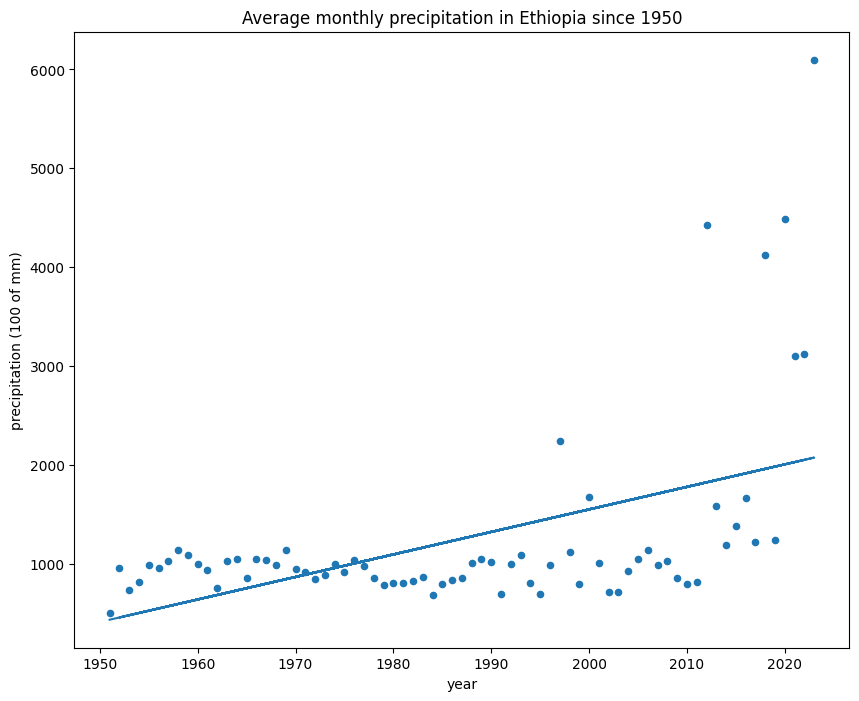

In [ ]:
pdfs_year.plot.scatter(
    x ='year(date)', y = 'avg(precipitation)', xlabel = 'year',
    ylabel = 'precipitation (100 of mm)',
    title = "Average monthly precipitation in Ethiopia since 1950", figsize = (10, 8)
                       )
# fix the axes values
x = pdfs_year['year(date)']
y = pdfs_year['avg(precipitation)']
#calculate equation for trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x, p(x))

# Show the plot
plt.show()

From the above time series figure of precipitation we can generally conclude that there has been a slight increasing trend in rainfall for the past 73 years. Moreover, an extraordinarily high picks in precipitation were recorded between 2010 and 2023.

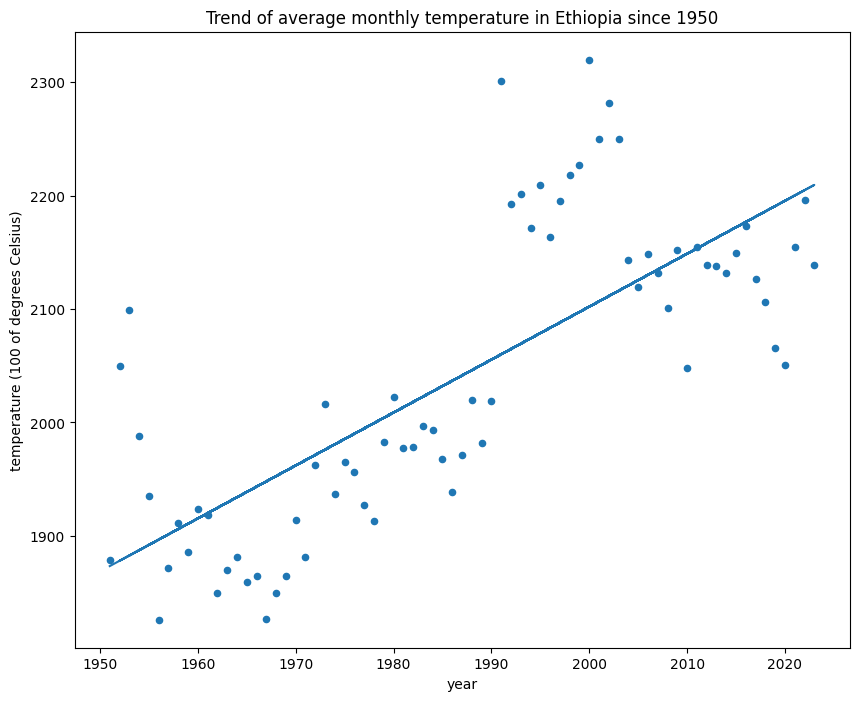

In [ ]:
pdfs_year.plot.scatter(
    x ='year(date)', y = 'avg(temperature)', xlabel = 'year',
    ylabel = 'temperature (100 of degrees Celsius)',
    title = "Trend of average monthly temperature in Ethiopia since 1950",
    figsize = (10, 8)
    )
x = pdfs_year['year(date)']
y = pdfs_year['avg(temperature)']
#calculate equation for trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x, p(x))

# Show the plot
plt.show()

From the abouve scatter plot and the fitted trendline, we can imagine that Ethiopia has experienced a significant increase in temperature. The average temperature increased from 18.8 in 1950 to 22.8 degrees Celsius in 2023. That means, every year the average temperature increases by 0.04 degrees Celsius. That is a remarkable figure.

### 7.3) Make some plots and investigate the results

Make some more histograms to visulaize the data and draw some insgights.

array([[<Axes: title={'center': 'avg(precipitation)'}>]], dtype=object)

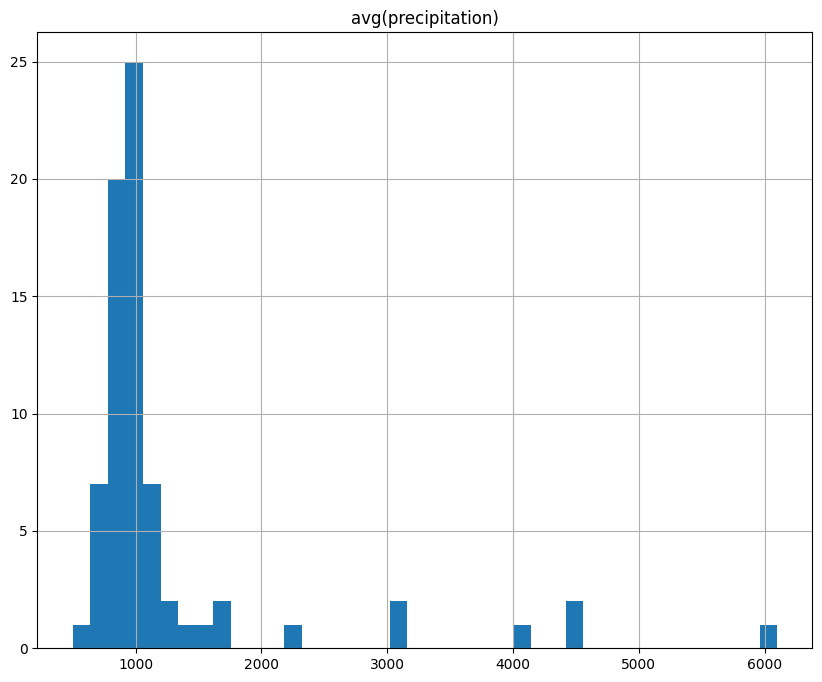

In [ ]:
pdfs_year.hist('avg(precipitation)', bins = 40, figsize = (10, 8))

From the above histograph we can undestand that most of the time the rainfall amount has ben 10mm or less (Not that 1000 is the most frequesnt value, and precipitation is meansure in 100 of millimeters)

array([[<Axes: title={'center': 'avg(temperature)'}>]], dtype=object)

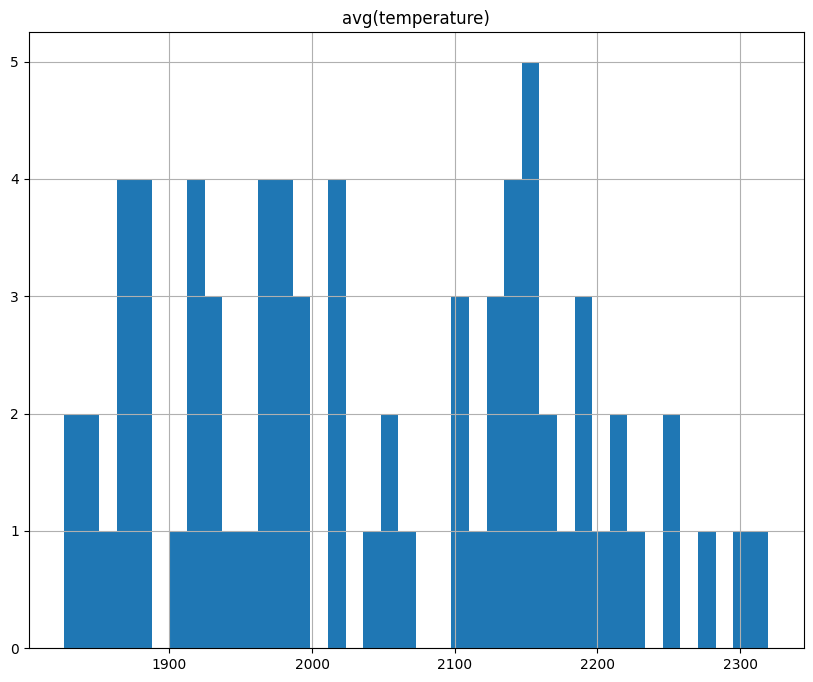

In [ ]:
pdfs_year.hist('avg(temperature)', bins = 40, figsize = (10, 8))

The above histogram tells us that the mode of average temperature of Ethiopia for the past 73 years is nearly 21.5 degrees Celsius.

### 7.4) Make some bar plots to undestand, visualize and infer data for each station

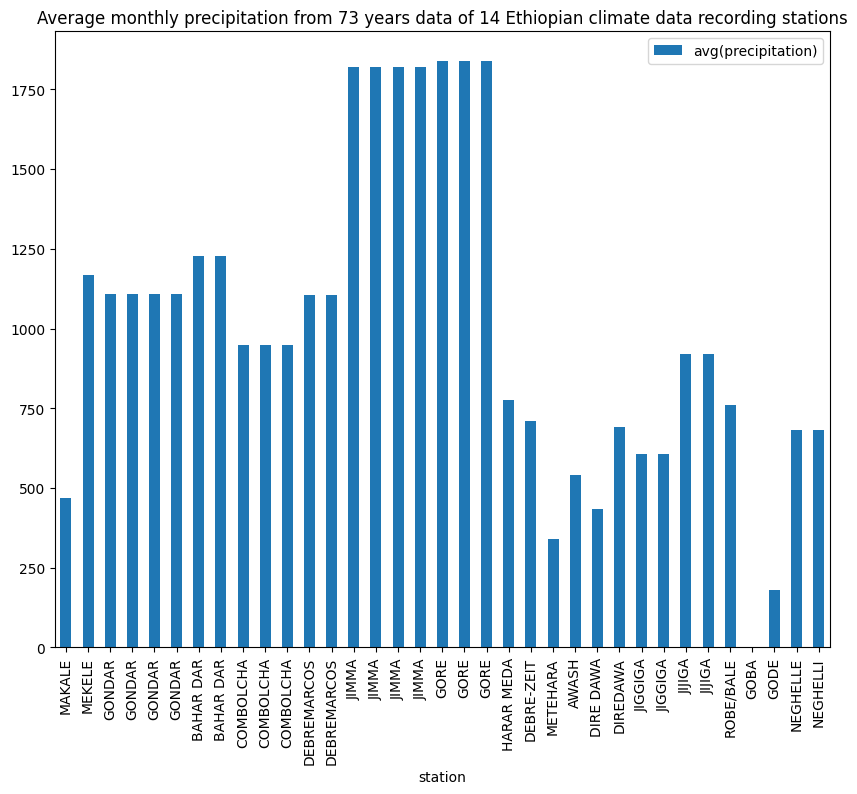

In [ ]:
ax = pdfs_station.plot.bar(
    x = 'station', y = 'avg(precipitation)', figsize = (10, 8),
    title = "Average monthly precipitation from 73 years data of 14 Ethiopian climate data recording stations"
                           )

From the above bar chart we can understand that the average monthly preci;itation for Gore town is the maximum, forllowed by Jimma. Gore is a town located in the westmost part of Ethiopia, near Gambela City. And Jimma is also a major city in the mid-western part of Ethiopia. We have to notice that those town are located on at a close visinity of the most dense forest area of the nation. It is also important to note that major cities like Dire Dawa and Mekele are among the driest regions. Gode is the driest town, followed by Metehara (a located along Awash river in Afar Region of the Rift Valley).

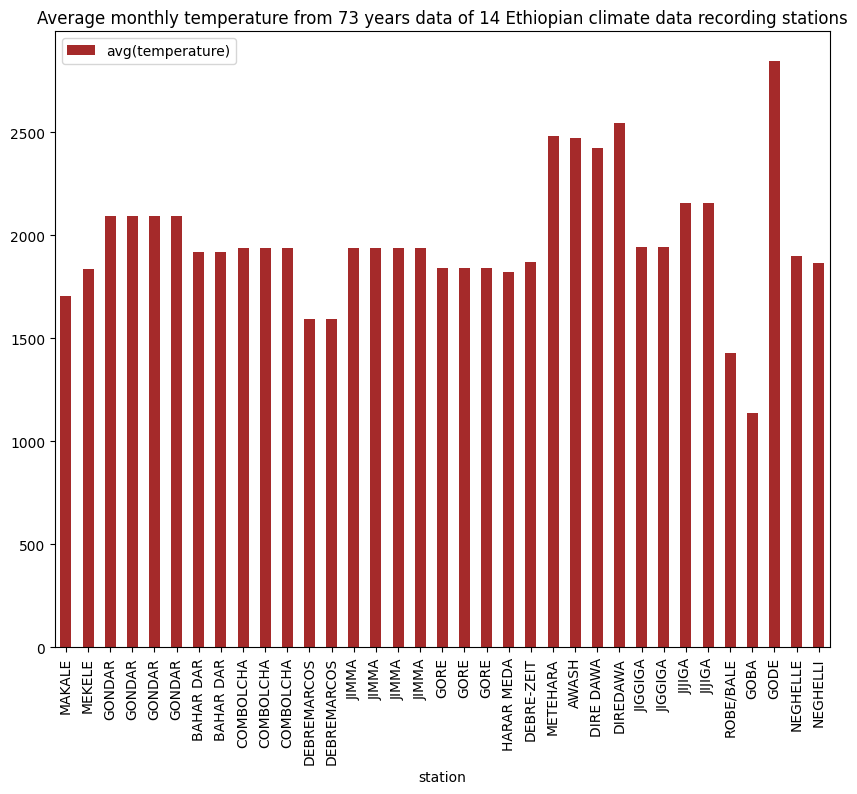

In [ ]:
ax = pdfs_station.plot.bar(
    x = 'station', y = 'avg(temperature)', figsize = (10, 8), color = 'brown',
    title = "Average monthly temperature from 73 years data of 14 Ethiopian climate data recording stations"
                           )

From the previous bar chart, we noticed that town of Gode in Southern part of Somali region is the most rain-scace town. Not from this temperature graph, it is not a surprise that Gode is the hottest town. Goba, in Bale Zone of Oromia Region is the colderst town.

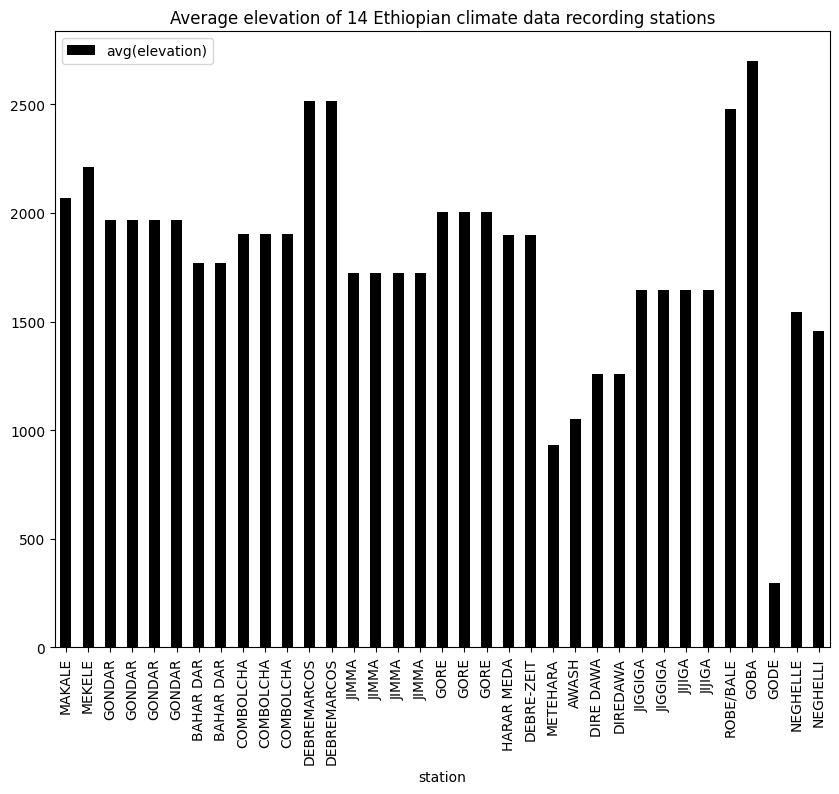

In [ ]:
ax = pdfs_station.plot.bar(
    x = 'station', y = 'avg(elevation)', figsize = (10, 8), color = 'black',
    title = "Average elevation of 14 Ethiopian climate data recording stations"
                           )

From the above graph, we can undestand that Goba it located at the highest elevation among all stations, followed by Robe and Debremarkos. That is why Goba's temperature is the lowest (see the previous bar chart)

## 8) Machine learning

We will use a simple machine learning algorithm: Linear Regression

### 8.1) Import some vital libraries

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
from pandas.plotting import scatter_matrix
numeric_features = [t[0] for t in station_6.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = station_6.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

### 8.2) Prepare data for Machine Learning. And we need two columns only — features and label(“Priciptation”):

In [ ]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(
    inputCols = ["lon","lat", "avg(elevation)", "avg(temperature)",
                 "avg(elevation)"], outputCol = 'features')
data_ml = vectorAssembler.transform(station_6)
data_ml = data_ml.select(['features', "avg(precipitation)"])
data_ml.show(3)

Split the data into training and validation

In [ ]:
splits = data_ml.randomSplit([0.7, 0.3])
train_data = splits[0]
test_data = splits[1]

In [ ]:
#print(splits.show(3))
print(train_data.show(3))
print(test_data.show(3))

### 8.3) Model building

We are using linear regression

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='PRCP',
                      maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data)

In [ ]:
lr_model.summary

In [ ]:
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

### 8.4) Summary of Model over train model

In [ ]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

In [ ]:
train_data.describe().show()

### 8.5) Prediction

In [ ]:
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("prediction","PRCP","features").show(20)

### 8.6) Model Evaluation

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="PRCP",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

In [ ]:
test_result = lr_model.evaluate(test_data)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

In [ ]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

In [ ]:
predictions = lr_model.transform(test_data)
predictions.select("prediction","PRCP","features").show()

## 9) Geospatial analysis and visualization

### 9.2) Import the necessary packages for geo-visualization

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

#### 9.2.1) Prepare a basemap for Ethiopia

A separately prepared shapefile can be imported for Ethiopia from local drive and can be plotted as follows. Then the overlay comes later.

In [ ]:
ethiopia = '/content/drive/MyDrive/IGSSA_AAU/Year_1/Big_Data/B1_Ethiopian_States.zip'

In [ ]:
et_gpd1 = gpd.read_file(ethiopia)

Have a look at the contents of the attibute table, note the names of the regions, for example

In [ ]:
et_gpd1.head()

,Region_Nam,Shape_Leng,Shape_Area,geometry
0,Harari,0.988836,0.027420,"POLYGON ((42.11103 9.39906, 42.11204 9.39897, ..."
1,Dire Dawa,2.435849,0.128127,"POLYGON ((42.37826 9.84194, 42.37868 9.84055, ..."
2,Tigray,16.274712,4.324521,"POLYGON ((39.25754 14.46433, 39.26467 14.41144..."
3,Amhara,32.261158,12.839396,"POLYGON ((36.10807 13.88507, 36.11737 13.88509..."
4,Oromiya,76.059040,24.406076,"MULTIPOLYGON (((36.95206 5.14409, 36.95159 5.1..."


Check if the geopandas file has a coordinate system. If not projected, then project it.

In [ ]:
if et_gpd1.crs != "EPSG:4326":
    et_gpd1.crs = {'init': 'EPSG:4326'}
else:
    pass

Plot the regions, to have the first impression on the country's map and its regions.

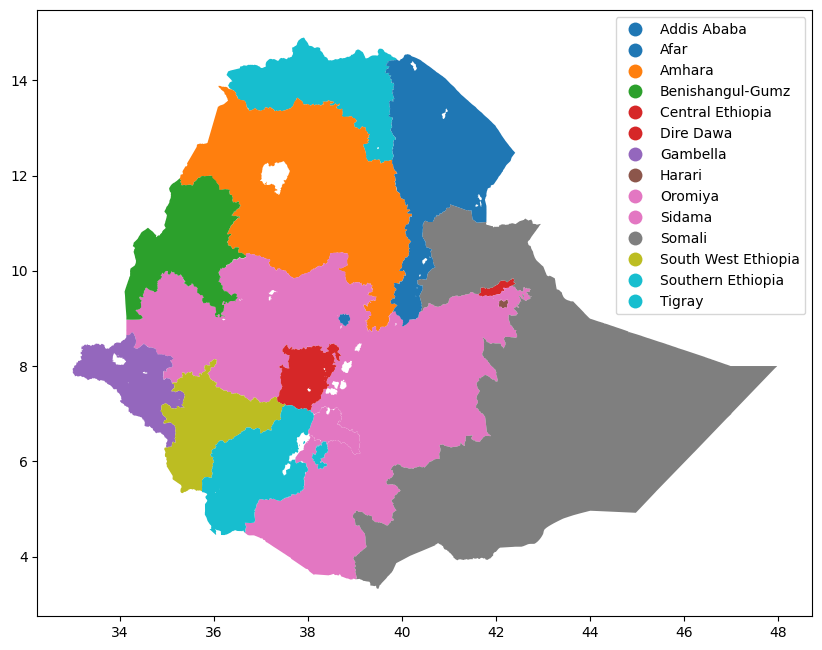

In [ ]:
et_gpd1.plot(column = "Region_Nam", categorical = False, legend = True, figsize=(10,8))
plt.show()

We do not need the colors of the regions for out analysis. Therefore we can the coloring as follows.

<Axes: >

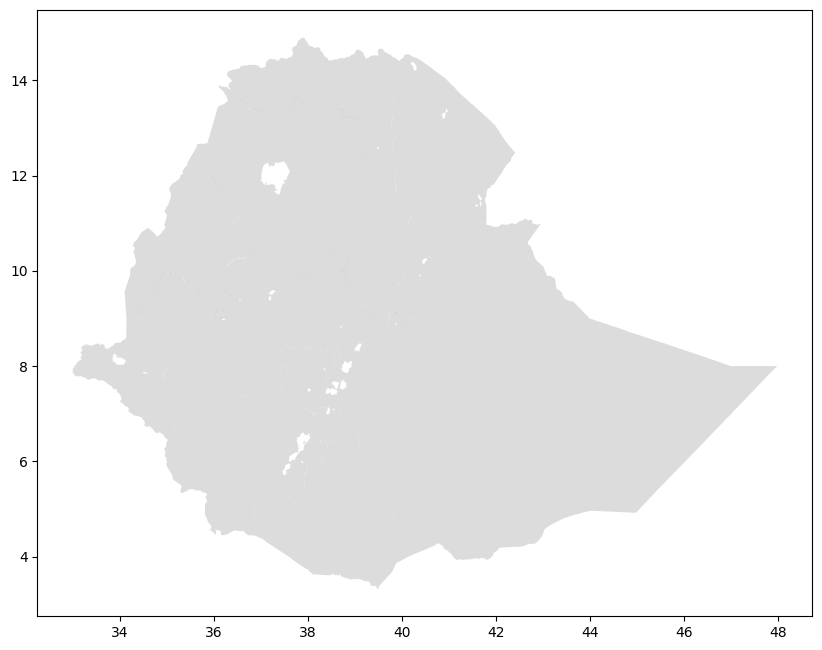

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
et_gpd1.plot(ax=ax, alpha=0.4, color='darkgrey')

#### 9.2.2) Prepare the precipitation and temperature datafarames for geopandas.

Now our basemap is ready. So let bring out data and overlay them into this basemap. To convert our dataframes into geopandas we need to contstuct the geometry from the longitude latitude columns.

Pandas to geopadas

In [ ]:
geodf = gpd.GeoDataFrame(pdfs_station, geometry = gpd.points_from_xy(pdfs_station.lon, pdfs_station.lat), crs = "EPSG:4326")

In [ ]:
geodf.head()

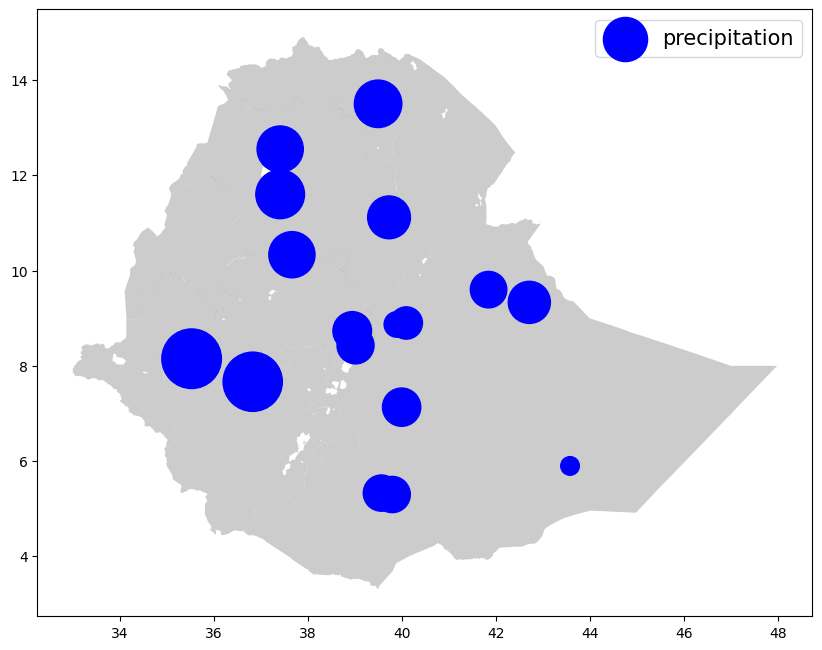

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
et_gpd1.plot(ax=ax, alpha=0.4, color='grey')
geodf[geodf['avg(precipitation)'] >= 100].plot(
    ax=ax, markersize = 'avg(precipitation)',
    color='blue', marker='o', label='precipitation'
    )
plt.legend(prop={'size':15})

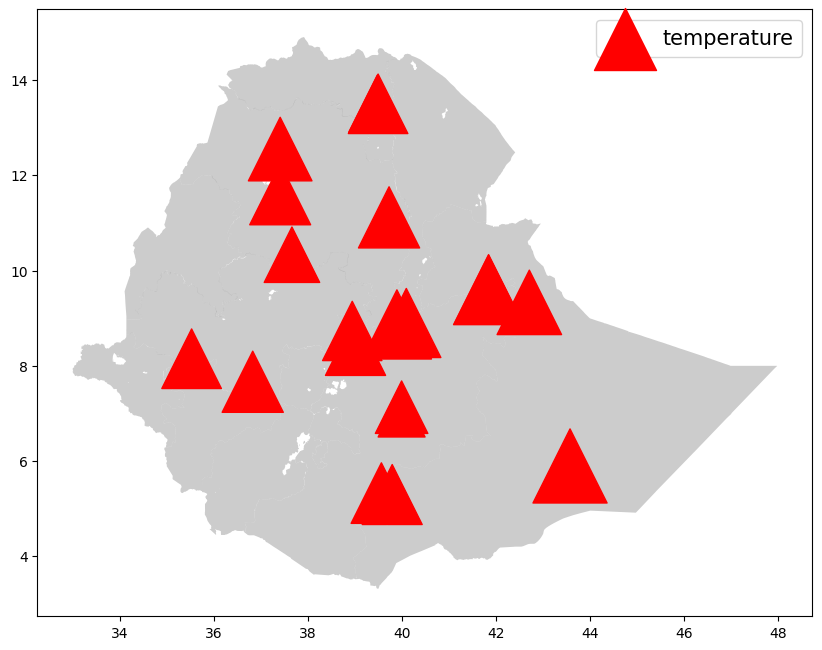

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
et_gpd1.plot(ax=ax, alpha=0.4, color='grey')
geodf[geodf['avg(temperature)'] >= 100].plot(
    ax=ax, markersize= ('avg(temperature)'), color='red',
    marker ='^', label='temperature'
    )
plt.legend(prop={'size':15})

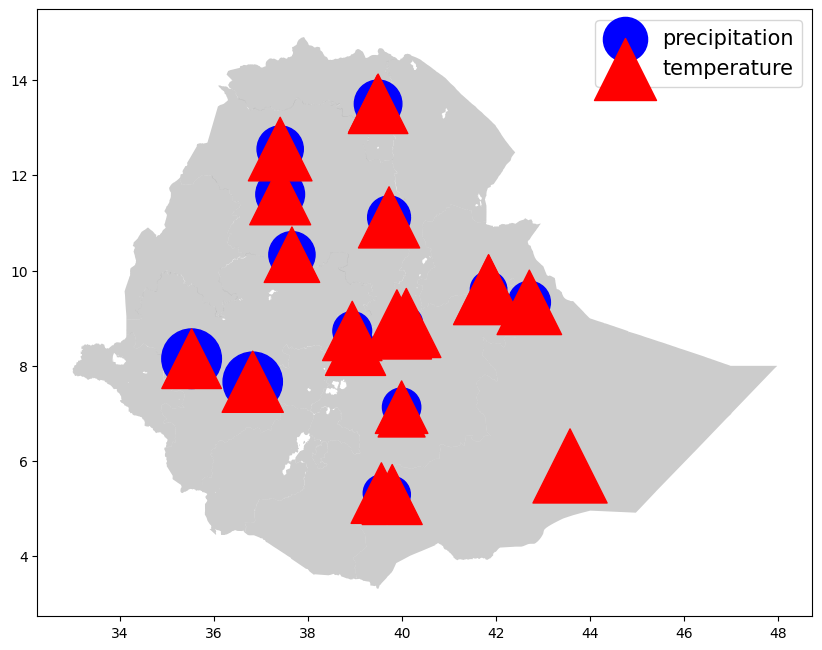

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
et_gpd1.plot(ax=ax, alpha=0.4, color='grey')

# Plot for precipitation
geodf[geodf['avg(precipitation)'] >= 100].plot(
    ax=ax, markersize='avg(precipitation)', color='blue',
    marker='o', label='precipitation')

# Plot for average temperature
geodf[geodf['avg(temperature)'] >= 100].plot(
    ax=ax, markersize='avg(temperature)', color='red',
    marker='^', label='temperature')

# Fixe the size of legend text
plt.legend(prop={'size':15})

The size of the **blue circles** correspond to the amount of the precipitation, while the size of **red triangles** corresponds to the level of temperature.

In [ ]:
pip install nbconvert

# End of the project